<a href="https://colab.research.google.com/github/jean-johnson-zwix/calorify/blob/main/dm_calorify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image, ImageDraw, ImageFont
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from io import BytesIO
import cv2
import os
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import default_data_collator
from transformers import TrainingArguments, Trainer
import torch

In [ ]:

# Load the pretrained model
processor = AutoImageProcessor.from_pretrained("LightDestory/upernetconvnext-finetuned-segments-food-oct-14")
model = UperNetForSemanticSegmentation.from_pretrained("LightDestory/upernetconvnext-finetuned-segments-food-oct-14")

# Load the dataset
raw_dataset = load_dataset("EduardoPacheco/FoodSeg103", split={"train": "train[:500]", "validation": "validation"})

train_dataset = raw_dataset["train"]
val_dataset = raw_dataset["validation"]


image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

def collate_fn(batch):
    pixel_values_list = []
    labels_list = []

    for item in batch:
        image = item["image"].convert("RGB")
        label = item["label"].convert("L")

        # Process image using processor
        processed_inputs = processor(images=image, return_tensors="pt")
        pixel_values = processed_inputs["pixel_values"][0]

        # Process label
        label_tensor = mask_transform(label).squeeze(0).long()

        pixel_values_list.append(pixel_values)
        labels_list.append(label_tensor)

    # Stack into batch tensors
    pixel_values = torch.stack(pixel_values_list)
    labels = torch.stack(labels_list)

    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Verify the output of the DataLoader
for batch in train_dataloader:
    break

batch = next(iter(train_dataloader))
print("Image batch shape:", batch["pixel_values"].shape)
print("Label batch shape:", batch["labels"].shape)


training_args = TrainingArguments(
    output_dir="./finetuned-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    gradient_accumulation_steps=4,
    fp16=True,
    num_train_epochs=5,
    save_total_limit=2,
    remove_unused_columns=False,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn
)

trainer.train()

preprocessor_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/327M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.71k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

Image batch shape: torch.Size([4, 3, 512, 512])
Label batch shape: torch.Size([4, 512, 512])


Epoch,Training Loss,Validation Loss
1,No log,2.508283
2,No log,2.328462
3,No log,2.209415
4,No log,2.145720


TrainOutput(global_step=205, training_loss=2.057200213176448, metrics={'train_runtime': 1367.9263, 'train_samples_per_second': 1.828, 'train_steps_per_second': 0.15, 'total_flos': 9.43818908576514e+17, 'train_loss': 2.057200213176448, 'epoch': 4.88622754491018})

In [ ]:
torch.save(model.state_dict(), 'calorify_model.pt')

In [ ]:
food_class_names = model.config.id2label
calorie_map = {
    0: 0,       # background
    1: 475,     # candy
    2: 290,     # egg tart
    3: 312,     # french fries
    4: 546,     # chocolate
    5: 430,     # biscuit
    6: 387,     # popcorn
    7: 143,     # pudding
    8: 207,     # ice cream
    9: 717,     # cheese butter
    10: 350,    # cake
    11: 85,     # wine
    12: 210,    # milkshake
    13: 2,      # coffee (black)
    14: 45,     # juice
    15: 42,     # milk
    16: 1,      # tea
    17: 575,    # almond
    18: 127,    # red beans
    19: 553,    # cashew
    20: 325,    # dried cranberries
    21: 173,    # soy
    22: 654,    # walnut
    23: 567,    # peanut
    24: 143,    # egg
    25: 52,     # apple
    26: 282,    # date
    27: 48,     # apricot
    28: 160,    # avocado
    29: 89,     # banana
    30: 32,     # strawberry
    31: 50,     # cherry
    32: 57,     # blueberry
    33: 52,     # raspberry
    34: 60,     # mango
    35: 115,    # olives
    36: 39,     # peach
    37: 29,     # lemon
    38: 57,     # pear
    39: 74,     # fig
    40: 50,     # pineapple
    41: 69,     # grape
    42: 61,     # kiwi
    43: 34,     # melon
    44: 47,     # orange
    45: 30,     # watermelon
    46: 271,    # steak
    47: 242,    # pork
    48: 239,    # chicken duck
    49: 301,    # sausage
    50: 350,    # fried meat
    51: 294,    # lamb
    52: 150,    # sauce (avg)
    53: 97,     # crab
    54: 206,    # fish (avg)
    55: 170,    # shellfish
    56: 99,     # shrimp
    57: 50,     # soup (avg)
    58: 265,    # bread
    59: 96,     # corn
    60: 295,    # hamburg
    61: 266,    # pizza
    62: 220,    # hanamaki baozi
    63: 195,    # wonton dumplings
    64: 158,    # pasta
    65: 138,    # noodles
    66: 130,    # rice
    67: 237,    # pie
    68: 76,     # tofu
    69: 25,     # eggplant
    70: 77,     # potato
    71: 149,    # garlic
    72: 25,     # cauliflower
    73: 18,     # tomato
    74: 43,     # kelp
    75: 45,     # seaweed
    76: 32,     # spring onion
    77: 20,     # rape (leafy greens)
    78: 80,     # ginger
    79: 33,     # okra
    80: 15,     # lettuce
    81: 26,     # pumpkin
    82: 16,     # cucumber
    83: 18,     # white radish
    84: 41,     # carrot
    85: 20,     # asparagus
    86: 27,     # bamboo shoots
    87: 34,     # broccoli
    88: 16,     # celery stick
    89: 12,     # cilantro mint
    90: 42,     # snow peas
    91: 25,     # cabbage
    92: 33,     # bean sprouts
    93: 40,     # onion
    94: 20,     # pepper
    95: 31,     # green beans
    96: 35,     # French beans
    97: 33,     # king oyster mushroom
    98: 34,     # shiitake
    99: 37,     # enoki mushroom
    100: 33,    # oyster mushroom
    101: 22,    # white button mushroom
    102: 80,    # salad (dressed avg.)
    103: 100    # other ingredients (default)
}


# PREDICTING USING THE MODEL

In [ ]:
!pip install transformers

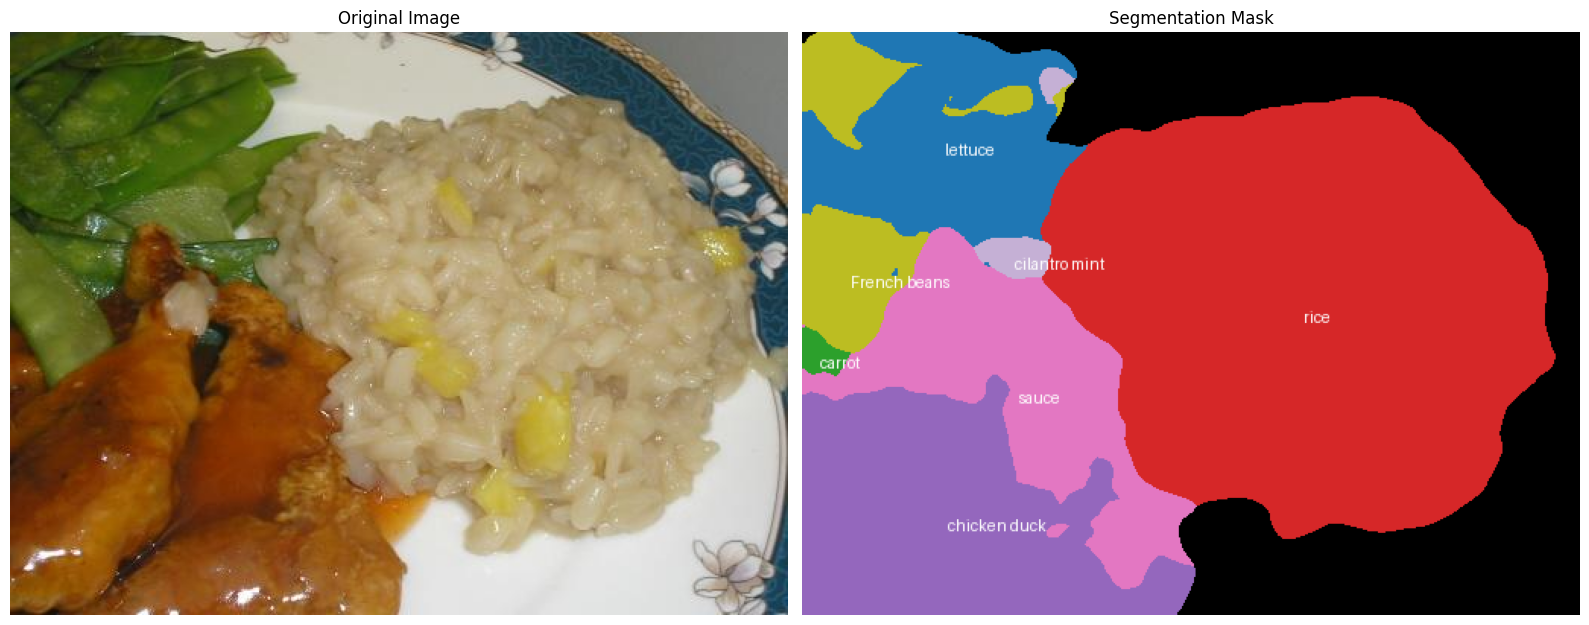

In [ ]:
# Get the class names
class_name_mapping = model.config.id2label

MIN_MASK_AREA = 300

# Load the image to predict
def load_image(image_path):
    if os.path.exists(image_path):
      return Image.open(image_path).convert("RGB")
    else:
      print(f"File not found: {image_path}")
      return None

image = load_image('/content/food_image1.jpg')


# Ensure model is on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).float()  # Also convert to float32 if using CPU

# Preprocess image
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# postprocess image
segmentation_masks = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])
predicted_mask_np = segmentation_masks[0].cpu().numpy().astype(np.uint8)

# visualizations
def visualize(mask, class_names, min_area=200):
    height, weight = mask.shape
    color_map = plt.colormaps.get_cmap('tab20')

    mask_rgb = np.zeros((height, weight, 3), dtype=np.uint8)
    label_layer = Image.new("RGBA", (weight, height))
    draw = ImageDraw.Draw(label_layer)

    font = ImageFont.load_default()

    for cls_id in np.unique(mask):
        if cls_id == 0:
            continue

        color = (np.array(color_map(cls_id % 20)) * 255).astype(np.uint8)[:3]
        mask_rgb[mask == cls_id] = color

        binary_mask = (mask == cls_id).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_area:
                continue

            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            class_name = class_names.get(cls_id, f"class_{cls_id}")
            draw.text((cx, cy), class_name, fill="white", font=font)
            break

    mask_with_labels = Image.fromarray(mask_rgb).convert("RGBA")
    final_mask = Image.alpha_composite(mask_with_labels, label_layer)
    return final_mask.convert("RGB")

# Display segmentation
labeled_mask_image = visualize(predicted_mask_np, class_name_mapping, min_area=MIN_MASK_AREA)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(labeled_mask_image)
plt.title("Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Constants
dpi = 96
inch_per_pixel = 1 / dpi
cm_per_pixel = inch_per_pixel * 2.54
area_per_pixel_cm2 = cm_per_pixel ** 2

# Compute area in pixels using contours
def compute_class_areas(mask_np, min_area=100):
    class_areas = {}
    for cls_id in np.unique(mask_np):
        if cls_id == 0:
            continue
        binary_mask = (mask_np == cls_id).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        total_area_px = 0
        for cnt in contours:
            area_px = cv2.contourArea(cnt)
            if area_px >= min_area:
                total_area_px += area_px
        if total_area_px > 0:
            class_areas[cls_id] = total_area_px
    return class_areas

# Calculate area and estimated calories
class_areas_px = compute_class_areas(predicted_mask_np, min_area=MIN_MASK_AREA)
class_areas_cm2 = {cls_id: area_px * area_per_pixel_cm2 for cls_id, area_px in class_areas_px.items()}

# Compute calories from area (assume 100 cm² ≈ 100g)
print(f"Food Items Identified\n")

area_values = list(class_areas_px.values())
threshold = np.percentile(area_values, 50)  # top 50% by area

total_calories = 0
for cls_id, area_px in class_areas_px.items():
    if area_px >= threshold:
        area_cm2 = class_areas_cm2[cls_id]
        class_name = class_name_mapping.get(int(cls_id), f"class_{cls_id}")
        kcal_per_100g = calorie_map.get(int(cls_id), 0)

        # Estimate calories
        estimated_kcal = (area_cm2 / 100.0) * kcal_per_100g
        total_calories += estimated_kcal

        print(f"{class_name:25}: {area_px:6.0f} px ≈ {area_cm2:.2f} cm² → ~{estimated_kcal:.1f} kcal")

print(f'Total calories: {total_calories}')

Food Items Identified

chicken duck             :  26331 px ≈ 18.43 cm² → ~44.1 kcal
sauce                    :  19896 px ≈ 13.93 cm² → ~20.9 kcal
rice                     :  72203 px ≈ 50.55 cm² → ~65.7 kcal
lettuce                  :  17338 px ≈ 12.14 cm² → ~1.8 kcal
Total calories: 132.47599652821182
